In [1]:
import numpy as np
import matplotlib
import numpy as np
import scipy.stats as sst
import scipy as sp
import matplotlib.pylab as plt
import scipy.spatial.distance as ssp
import pandas as pd

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.theo_variogram_fct as vario

import datetime
import helpers.kriging as kri
import helpers.variogram as variokri

# Parameters

In [2]:
seed = 200
n_cond = 10

# Load data and initial statistics

In [3]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])


#to define grid (to match sample points with each cell of grid)
delta_x = 1000        #meters (it depends on the data set dimensions)
delta_y = delta_x     #meters. To keep square cells

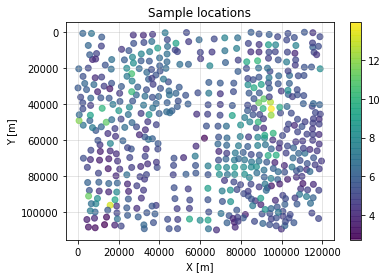

In [4]:
#Scatter plot of samples
y = xyz[:,0] #The first coordenate is y rather than x as usual.
x = xyz[:,1]
z = xyz[:,2]

xy = np.dstack([x, y])[0]

plt.scatter(x, y, c=z, alpha=0.7)
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.title('Sample locations')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True, alpha=0.4)
plt.savefig('1_sample_original_points_map.png', dpi=300) #save a nice .png of this map.

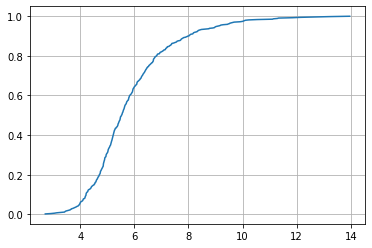

In [5]:
#Calculates the cummulative distribution function of data z
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)


#Original data
plt.figure()
plt.grid()
plt.plot(values_cdf, cdf)
plt.savefig('2_CDF_Original_data.png', dpi=300) #save a nice .png of this map.

min = -2.9058541750122475 max = 2.861769176055261


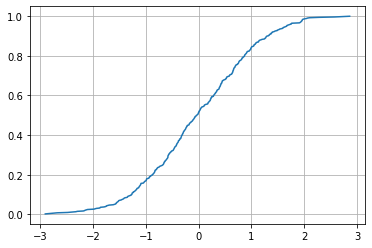

In [6]:
#Data to be transformed
np.random.seed(1000)
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)
plt.grid()
plt.savefig('3_CDF_Normal_data.png', dpi=300) #save a nice .png of this map.
print("min =", min(normal_data), "max =", max(normal_data))


In [7]:
#Normalization of data z
z_norm = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]                        #finds cummulative probability of the value
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)  #To make it continous
    z_norm.append(inter(cdf[pos]))                                 #looks for the normalized value with the same cumm probability

z_norm = np.array(z_norm)

print('max z normalized value =', max(z_norm))
print('min z normalized value =', min(z_norm))

max z normalized value = 2.861769176055261
min z normalized value = -2.9058541750122475


total number of distances = 144991
max distance = 155400.2 [m]
min distance = 1419.2 [m]
dimensions of D =  (539, 539)


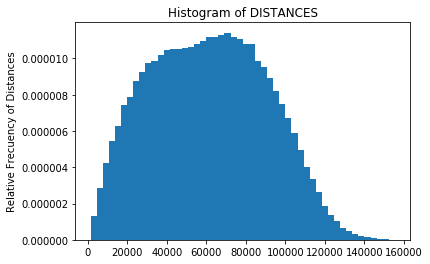

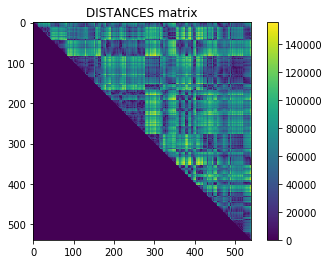

In [8]:
H = ssp.pdist(xy, metric='euclidean') #Distance array
D = ssp.squareform(H) #Distance matrix
upper = np.triu(D)
upper_vector = np.matrix.flatten(upper)
upper_vector = upper_vector[upper_vector>0]
print("total number of distances =", upper_vector.shape[0])
plt.hist(upper_vector, bins = 50, density='true') # bins = np.arange(0, np.round(max(H),0)+1 , delta_x)
plt.title("Histogram of DISTANCES")
plt.ylabel('Relative Frecuency of Distances')
print("max distance =",np.round(max(H),1),"[m]")
print("min distance =",np.round(min(H),1),"[m]")
print("dimensions of D = ",upper.shape)
plt.savefig('3_Histogram_Distances.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.imshow(upper)
plt.title("DISTANCES matrix")
plt.colorbar()
plt.savefig('4_Distances_matrix.png', dpi=300) #save a nice .png of this map.

### Correlogram

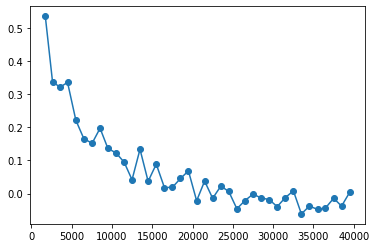

In [9]:
n = np.linspace(1000,40000,40)
bins = np.array(n)

ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances


F = z_norm

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1])) #data index between evaluated distances
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0] #Correlation
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,rs,'o-')
plt.savefig('5_Correlogram.png', dpi=300) #save a nice .png of correlogram.

### Empirical Variogram

In [10]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    sem_vars.append(sem_var_cur)
    

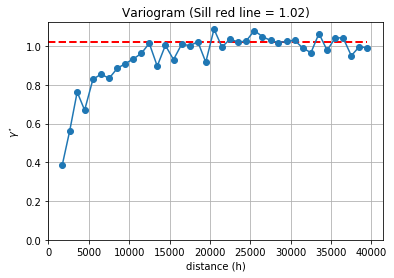

In [11]:
#Sill calculation
sill = np.var(z_norm)  #the sill is the variance of z normalized values
plt.hlines(y=sill, xmin=0, xmax=max(d_mean), colors='r', linestyles='--', lw=2) # plot sill as red dashed line.
plt.plot(d_mean, np.array(sem_vars), marker ='o')                               # plot empirical variogram
plt.grid(True)
plt.title('Variogram (Sill red line = ' + str(np.round(sill,2)) + ')')
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)
plt.savefig('6_Variogram.png', dpi=300) #save a nice .png of the variogram
plt.show()

### Initialize grid and assignation of sample values to proper cells

In [12]:
nx = 2 + int(max(x)/delta_x)       #number of required cells in x-axis
ny = 2 + int(max(y)/delta_y)       #number of required cells in y-axis
print("x max =", max(x), ", y max =", max(y))
print("This map requires", nx, "cells in x-axis and", ny,"in y-xis")

x max = 119592.0 , y max = 109987.0
This map requires 121 cells in x-axis and 111 in y-xis


In [13]:
#Initialize grid
X,Y = np.mgrid[0:int(delta_y+max(y)):delta_y, 0:int(delta_x+max(x)):delta_x] #is assigned y-related to row and x-related to columns

#Initialize the entire matrix with "None" values
Z = np.zeros([X.shape[0],X.shape[1]])  #it can be with X.shape or Y.shape coz both have same dimensions.
Z[:,:]=None
print('Z dimensions =',Z.shape)


Z dimensions = (111, 121)


max_z_normal value = 2.861769176055261
min_z_normal value = -2.9058541750122475


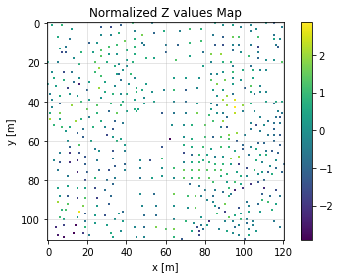

In [14]:
#Assign value of normalized samples (z) to corresponding cells in initialized matrix (Z)

i=0
observations_index = []
while i< x.shape[0]:
    x_i = int(np.round(x[i]/delta_x,0))  #return x_i = colum
    y_i = int(np.round(y[i]/delta_y,0))
    Z[y_i,x_i] = z_norm[i]
    observations_index.append([y_i,x_i])
    i = i+1

print('max_z_normal value =', max(z_norm))
print('min_z_normal value =', min(z_norm))

plt.imshow(Z, aspect='equal')
plt.grid(True, alpha=0.4)
plt.colorbar()
plt.title('Normalized Z values Map')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.savefig('7_samples_in_grid_map.png', dpi=300) #save a nice .png of this map.

# Theoretical Variogram Models

In [15]:
# Define Dictionaries of Theoretical Variogram Models

# Dictionary for individual variogram models. Reference the theo_variogram_fct python file
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# Dictionary for individual short-form variogram models to be used for composited variogram models
mods = {'Exp': vario.ExponentialVariogram,
        'Sph': vario.SphericalVariogram,
        'Gau': vario.GaussianVariogram,
        'Lin': vario.LinearVariogram}

In [16]:
# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(d_mean, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()


In [17]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),decimals = 2)
h = np.linspace(0, max(d_mean),  int(max(d_mean)/10.))
var_range = np.round(np.max(np.array(d_mean)),decimals = 2)
print(np.max(np.array(sem_vars)))
print(var_sill)

1.086964200299213
1.09


# Interactive Plot 

With this interactive display, using slider bars, you can adjust the SILL and the RANGE for a Variogram Model selected from a dropdown list. The graph axes will update automatically.(taken from 05_model fitting)

In [18]:
# Trigger Interactive Plot
# recommended parameters : (sill = 1.03, range = 4344.7)
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/100,var_sill*1.5,0.01),
         Range = (0,max(h), max(h)/100),
         Model = models)

interactive(children=(FloatSlider(value=0.8209000000000001, description='Sill', max=1.6350000000000002, min=0.…

<function __main__.plot_varmodel(Sill, Range, Model)>

# Interpolate (Kriging)

In [19]:
controls = xy

if len(controls.shape)<3: #to avoid in multiple runs add more dimensions
    controls = controls[:, np.newaxis, :]
print(len(controls.shape))
print(controls.shape)

3
(539, 1, 2)


In [20]:
i_index, j_index = np.meshgrid(range(Z.shape[0]), range(Z.shape[1]), indexing='ij') #meshgrid with index 
index = np.column_stack((np.concatenate(i_index), np.concatenate(j_index))) #rows and columns append in order to have a vector of all possible indexes (i,j) in the matrix 

index_to_simulate = [i for i in index.tolist() if i not in observations_index] #Delete from the matrix the 'observed data'

xe = Y[0,:][np.array(index_to_simulate)[:,1]]#Columns are coordinate x
ye = X[:,0][np.array(index_to_simulate)[:,0]]#Rows are coordinate y

targets = np.column_stack((xe, ye))

print("Number of cell in meshgrid =",targets.shape[0])

Number of cell in meshgrid = 12892


In [21]:
# measurement values
controlvalues = z_norm
var_sample = np.var(controlvalues)


In [22]:
# Variogram Parameters
expo = variokri.ExponentialVariogram({'sill': 1.03,
                                   'range': 4344.70,
                                   'variance': var_sample})


#sph = variokri.SphericalVariogram({'sill': 1.03,
 #                            'range': 9084.37})


fitted_variogram = variokri.CompositeVariogram()
fitted_variogram.addVariogram(expo)

In [23]:
ok_results = []
interpolation_kri = np.copy(Z)
std_kri = np.zeros((Z.shape[0],Z.shape[1]))

ok_result = kri.krige_ok(controls
                       , targets
                       , controlvalues
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    interpolation_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[1]
    std_kri[index_to_simulate[i][0], index_to_simulate[i][1]] = result[2]
    ok_results.append([result[1], result[2]])

ID 	 x 	 y 	 est(z)


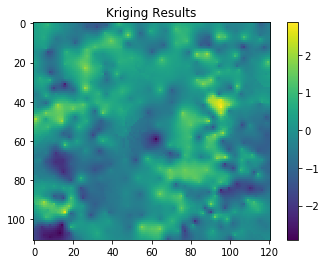

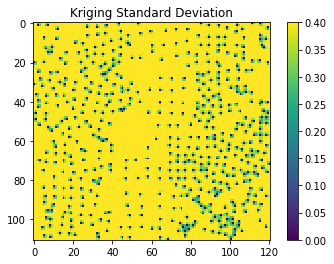

In [24]:

# plt.title('log(Kriging Results)')
# plt.imshow(np.log(interpolation_kri),
#           origin='lower')
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.show()

# plt.title('in rank space')
# plt.imshow(sst.rankdata(interpolation_kri.flatten()).reshape(Z.shape[0], Z.shape[1]),
#           origin='lower')
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.show()

plt.title('Kriging Results')
plt.imshow(interpolation_kri,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('8_Ordinary Kriging map.png', dpi=300) #save a nice .png of this map.
plt.show()

plt.title('Kriging Standard Deviation')
plt.imshow(std_kri,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('9_Kriging Variance map.png', dpi=300) #save a nice .png of this map.
plt.show()

### Random path function

In [25]:
#Montecarlo random path
def random_path(seed, index_to_simulate): 
    #This function gives a matrix of the length of the indexes in the matrix without the observed data. it gives 
    np.random.seed(seed)
    path = np.random.choice(len(index_to_simulate),size=len(index_to_simulate), replace=False)#gives random values to change the order of the indexes according to this list
    return np.array(index_to_simulate)[path]
    

coord_order = random_path(seed,index_to_simulate)#Indexes random


# SGS

In [26]:
interpolation_sgs = np.copy(Z)
std_sgs = np.zeros((Z.shape[0],Z.shape[1]))
controls_sgs = controls
controlvalues_sgs = controlvalues

for n in coord_order:
    targets_sgs =  np.array([[Y[0,n[1]], X[n[0],0]]]) #Select cell to calculate. It searches for the value of coordinates that n represents 
    ok_result = kri.krige_ok(controls_sgs
                       , targets_sgs
                       , controlvalues_sgs
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
    #Save data
    for i, result in enumerate(ok_result):
        interpolation_sgs[n[0], n[1]] = result[1] #Save calculated value with kriging
        std_sgs[n[0], n[1]] = result[2]
        controlvalues_sgs = np.append(controlvalues_sgs,result[1])#Add data to control values
    controls_sgs = np.append(controls_sgs, [targets_sgs], axis =0)#Add calculated coordinates to control coordinates


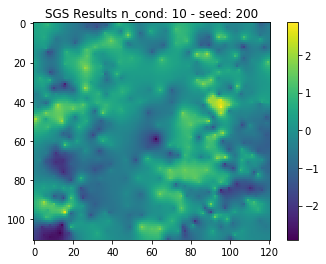

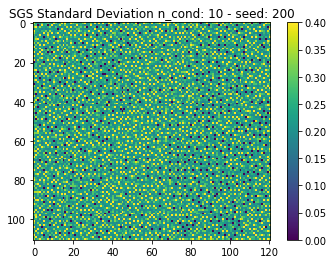

In [27]:
plt.imshow(interpolation_sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.title('SGS Results n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.savefig('10_SGS_map_normal_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()


plt.title('SGS Standard Deviation n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.imshow(std_sgs,
          origin='lower',
          vmin=0.0,
          vmax=0.4)
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.savefig('11_SGS_std_map_normal_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

## Back to original values units

In [28]:
#Back to original values of the data after Ordinary Kriging (without SGS)
ok_results_units_original = np.zeros((interpolation_kri.shape[0], interpolation_kri.shape[1]))
for i in range(interpolation_kri.shape[0]):
    for j in range(interpolation_kri.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_kri[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        ok_results_units_original[i,j] = inter(cdf_value)

#Back to original values of the data after SGS
sgs = np.zeros((interpolation_sgs.shape[0], interpolation_sgs.shape[1]))
for i in range(interpolation_sgs.shape[0]):
    for j in range(interpolation_sgs.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_sgs[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        sgs[i,j] = inter(cdf_value)

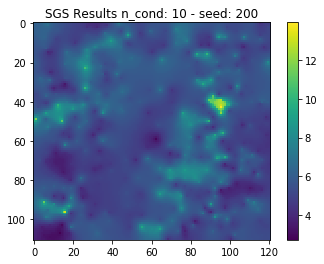

In [29]:
plt.imshow(sgs,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.title('SGS Results n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.savefig('12_SGS_map_realworld_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()


# Validation

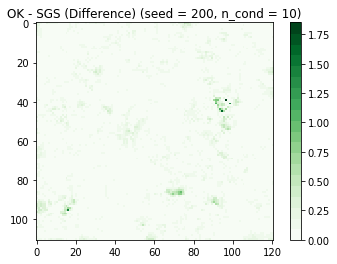

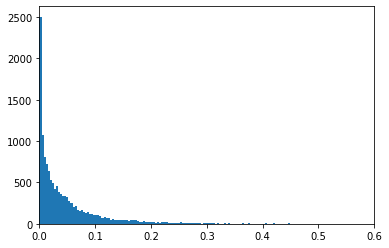

                  0
count  13431.000000
mean       0.049206
std        0.074631
min        0.000000
25%        0.006547
50%        0.025660
75%        0.062522
max        1.853078


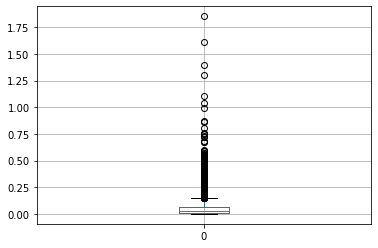

In [30]:
# plt.title('Ordinary Kriging Original units Result')
# plt.imshow(ok_results_units_original,
#           origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.savefig('Ordinary Kriging map_original_units.png', dpi=300) #save a nice .png of this map.
# plt.show()

# plt.title('SGS Original unit Result')
# plt.imshow(sgs,
#           origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
# plt.colorbar()
# plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
# plt.savefig('SGS Kriging map_original_units.png', dpi=300) #save a nice .png of this map.
# plt.show()

# Plot difference between different estimation methods.
difference_ok_sgs = abs(ok_results_units_original - sgs)
# print(difference_ok_sgs.flatten())

plt.title('OK - SGS (Difference) '+'(seed = '+str(seed)+', n_cond = '+str(n_cond)+')')
plt.imshow(difference_ok_sgs,
          origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.savefig('13_Difference_map_original_units_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

# #statistics of difference variable
plt.hist(difference_ok_sgs.flatten(), bins=500)
plt.xlim([0 , .6])
plt.savefig('14_Difference (OK-SGS) Histogram_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()
df = pd.DataFrame(difference_ok_sgs.flatten())
print(df.describe())
df.boxplot()

## Unconditional

In [31]:
coord_order_un = random_path(seed,index)   #Indexes random over "index" vector which contains all coordenates of grid.

interpolation_sgs_un = np.copy(Z)
std_sgs_un = np.zeros((Z.shape[0],Z.shape[1]))
controls_sgs_un = controls
controlvalues_sgs_un = controlvalues

for n in coord_order_un:
    targets_sgs_un =  np.array([[Y[0,n[1]], X[n[0],0]]]) #Select cell to calculate. It looks for the value of coordinates Y represents 
    ok_result = kri.krige_ok(controls_sgs_un
                       , targets_sgs_un
                       , controlvalues_sgs_un
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
    for i, result in enumerate(ok_result):
        interpolation_sgs_un[n[0], n[1]] = result[1]#Calculate kriging
        std_sgs_un[n[0], n[1]] = result[2]
        controlvalues_sgs_un = np.append(controlvalues_sgs_un,result[1])#Add cell to control values
    controls_sgs_un = np.append(controls_sgs_un, [targets_sgs_un], axis =0)#Add cell to control coordinates
    
###Problem: It will have duplicate values, the initial control data and the new calculated value.

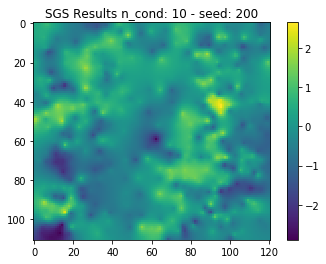

In [32]:
plt.imshow(interpolation_sgs_un,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.title('SGS Results n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.savefig('15_SGS_map_unconditional_normal_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

In [33]:
#Back to original values of the data after SGS
sgs_unconditional = np.zeros((interpolation_sgs_un.shape[0], interpolation_sgs_un.shape[1]))
for i in range(interpolation_sgs_un.shape[0]):
    for j in range(interpolation_sgs_un.shape[1]):
        inter_normal = sp.interpolate.interp1d(values_cdf_normal,cdf_normal)
        cdf_value = inter_normal(interpolation_sgs_un[i,j])
        inter = sp.interpolate.interp1d(cdf,values_cdf)
        sgs_unconditional[i,j] = inter(cdf_value)

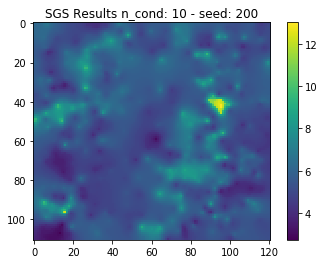

In [34]:
plt.imshow(sgs_unconditional,
          origin='lower')
plt.colorbar()
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.title('SGS Results n_cond: '+ str(n_cond) + ' - seed: ' + str(seed))
plt.savefig('16_SGS_map_unconditional_realworld_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

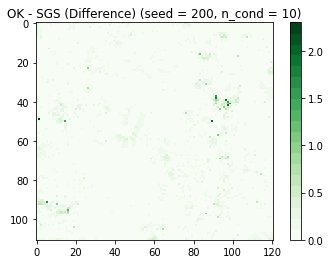

In [35]:
difference_ok_sgs = abs(ok_results_units_original - sgs_unconditional)
# print(difference_ok_sgs.flatten())

plt.title('OK - SGS (Difference) '+'(seed = '+str(seed)+', n_cond = '+str(n_cond)+')')
plt.imshow(difference_ok_sgs,
          origin='lower', cmap=plt.cm.get_cmap('Greens', 20))
plt.gca().invert_yaxis() #invert the y axis because is the nature of the data.
plt.colorbar()
plt.savefig('17_Difference_map_unconditional_realworld_'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this map.
plt.show()

# Cross-validation

In [36]:
estimated_values = []
std_estimated = []
for i in range(len(controls)):
    targets_cv = controls[i]
    #Delete known value from control data
    controls_cv = [u for u in controls_sgs if u not in controls[i]]
    controls_cv = np.array(controls_cv)
    controlvalues_cv = np.delete(controlvalues_sgs,i)
    #Calculate new value using sgs code
    ok_result = kri.krige_ok(controls_cv
                       , targets_cv
                       , controlvalues_cv
                       , fitted_variogram
                       , n_cond
                       , verbose = True)
    #Save estimated value to validate later
    for j, result in enumerate(ok_result):
        estimated_values.append(result[1]) 
        std_estimated.append(result[2])

In [37]:
RMSE = np.round((np.sqrt(np.mean((z_norm-estimated_values)**2.))), 2)

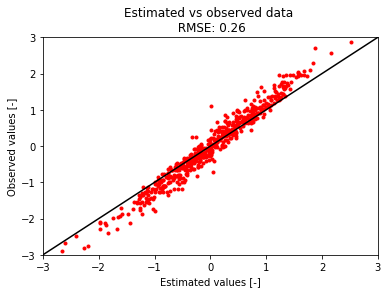

In [38]:
plt.title('Estimated vs observed data \n RMSE: '+str(RMSE))
diagonal=[-3,3]
plt.plot(estimated_values,z_norm,'r.') # x vs y
plt.plot(diagonal,diagonal,'k-')
plt.xlabel('Estimated values [-]')
plt.ylabel('Observed values [-]')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.savefig('18_CrossValidation_normal'+str(seed)+'_'+str(n_cond)+'.png', dpi=300) #save a nice .png of this figure.
plt.show()